In [ ]:
!pip install hypnettorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.9/456.9 kB 6.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = '.'

Reading MNIST dataset ...
Creating directory "./MNIST" ...
Reading labels from ./MNIST/train-labels-idx1-ubyte.gz.
Number of labels in current file: 60000
Reading labels from ./MNIST/t10k-labels-idx1-ubyte.gz.
Number of labels in current file: 10000
Reading images from ./MNIST/train-images-idx3-ubyte.gz.
Number of images in current file: 60000
Reading images from ./MNIST/t10k-images-idx3-ubyte.gz.
Number of images in current file: 10000
Elapsed time to read dataset: 29.319447 sec


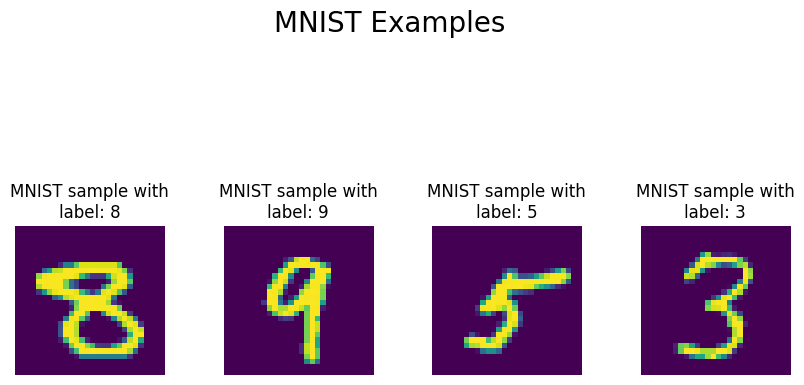

In [ ]:
from hypnettorch.data import MNISTData

#Import MNIST Dataset
mnist = MNISTData(data_dir, use_one_hot=True, validation_size=0)

# Get a batch of training samples from each data handler.
mnist_inps, mnist_trgts = mnist.next_train_batch(4)

# Plot sample MNIST data
mnist.plot_samples('MNIST Examples', mnist_inps, outputs=mnist_trgts)

In [ ]:
from hypnettorch.mnets import LeNet

# Instantiate Target LeNet
mnet = LeNet(in_shape=mnist.in_shape, num_classes=mnist.num_classes, arch='mnist_small', no_weights=True).to(device)

Creating a LeNet with 21840 weights.


In [ ]:
print(mnist.in_shape)

[28, 28, 1]


In [ ]:
from hypnettorch.hnets import HMLP

# Instantiate Hypernetwork HMLP
hnet = HMLP(mnet.param_shapes, uncond_in_size=0, cond_in_size=8, layers=[100, 100], num_cond_embs=2).to(device)

print('The randomly initialized input embeddings are:\n', hnet.conditional_params)

Created MLP Hypernet.
Hypernetwork with 2216856 weights and 21840 outputs (compression ratio: 101.50).
The network consists of 2216840 unconditional weights (2216840 internally maintained) and 16 conditional weights (16 internally maintained).
The randomly initialized input embeddings are:
 [Parameter containing:
tensor([-0.4074,  1.3019, -0.1785, -0.6598, -0.8330,  1.7798,  0.8138, -1.6778],
       requires_grad=True), Parameter containing:
tensor([-0.5865,  0.7597,  0.4861,  0.0900, -0.0679, -0.8063,  1.8475, -0.0055],
       requires_grad=True)]


In [ ]:
# Initialize network
hnet.apply_hyperfan_init(mnet=mnet)

In [ ]:
# Accuracy 

def calc_accuracy(data, mnet, mnet_weights):
    """Compute the test accuracy for a given dataset"""
    with torch.no_grad():
        # Process complete test set as one batch.
        test_in = data.input_to_torch_tensor( \
            data.get_test_inputs(), device, mode='inference')
        test_out = data.input_to_torch_tensor( \
            data.get_test_outputs(), device, mode='inference')
        test_lbls = test_out.max(dim=1)[1]

        logits = mnet(test_in, weights=mnet_weights)
        pred_lbls = logits.max(dim=1)[1]

        acc = torch.sum(test_lbls == pred_lbls) / test_lbls.numel() * 100.

    return acc

In [ ]:
# Configure training

lr=1e-4
batchsize=32
nepochs=10
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(nepochs): # For each epoch.

    # Iterate over the whole MNIST training set.
    i = 0
    for curr_batchsize, mx, my in mnist.train_iterator(batchsize):
        i += 1

        # Current mini-batch of MNIST samples.
        mnist_X = mnist.input_to_torch_tensor(mx, device, mode='train')
        mnist_Y = mnist.output_to_torch_tensor(my, device, mode='train')

        optimizer.zero_grad()

        # Compute MNIST loss.
        W_mnist = hnet(cond_id=0)
        mnist_P = mnet.forward(mnist_X, weights=W_mnist)
        loss_mnist = criterion(mnist_P, mnist_Y.max(dim=1)[1])
        
        # The total loss (add regularizers here)
        loss = loss_mnist
        loss.backward()
        optimizer.step()

        if i % 500 == 0:            
            print('[%d, %5d] loss: %.3f, MNIST acc: %.2f%%' % (epoch + 1, i + 1, loss.item(), calc_accuracy(mnist, mnet, W_mnist)))


print('Training finished with test-accs: MNIST acc: %.2f%%' % (calc_accuracy(mnist, mnet, W_mnist)))

[1,   501] loss: 0.011, MNIST acc: 95.48%
[1,  1001] loss: 0.086, MNIST acc: 96.28%
[1,  1501] loss: 0.015, MNIST acc: 97.35%
[2,   501] loss: 0.026, MNIST acc: 97.59%
[2,  1001] loss: 0.009, MNIST acc: 97.84%
[2,  1501] loss: 0.024, MNIST acc: 97.77%
[3,   501] loss: 0.170, MNIST acc: 97.33%
[3,  1001] loss: 0.239, MNIST acc: 97.95%
[3,  1501] loss: 0.029, MNIST acc: 97.59%
[4,   501] loss: 0.212, MNIST acc: 97.04%
[4,  1001] loss: 0.007, MNIST acc: 98.15%
[4,  1501] loss: 0.125, MNIST acc: 98.25%
[5,   501] loss: 0.011, MNIST acc: 98.01%
[5,  1001] loss: 0.088, MNIST acc: 98.40%
[5,  1501] loss: 0.058, MNIST acc: 98.53%
[6,   501] loss: 0.031, MNIST acc: 98.09%
[6,  1001] loss: 0.082, MNIST acc: 97.87%
[6,  1501] loss: 0.001, MNIST acc: 98.14%
[7,   501] loss: 0.002, MNIST acc: 98.50%
[7,  1001] loss: 0.022, MNIST acc: 98.09%
[7,  1501] loss: 0.010, MNIST acc: 98.32%
[8,   501] loss: 0.024, MNIST acc: 98.54%
[8,  1001] loss: 0.009, MNIST acc: 98.61%
[8,  1501] loss: 0.032, MNIST acc:

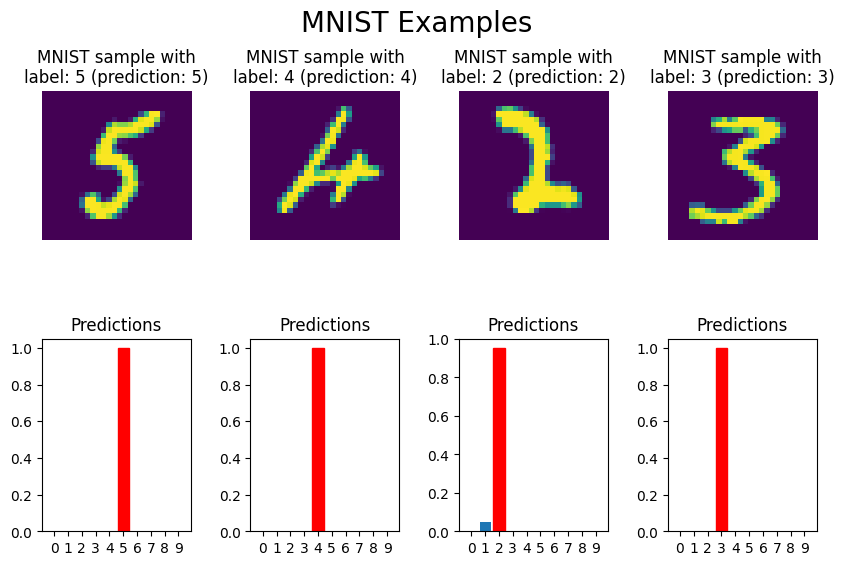

In [ ]:
# Get a batch of test samples from each data handler.
mnist_inps, mnist_trgts = mnist.next_test_batch(4)

# Compute predictions for test batches above.
with torch.no_grad():
    mnist_X = mnist.input_to_torch_tensor(mnist_inps, device, mode='inference')
    
    W_mnist = hnet(cond_id=0)
    mnist_preds = mnet.forward(mnist_X, weights=W_mnist)
    
    # Note, the network outputs are logits, and thus not normalized.
    mnist_preds = torch.softmax(mnist_preds, dim=1)
    
    mnist_preds = mnist_preds.detach().cpu().numpy()

mnist.plot_samples('MNIST Examples', mnist_inps, outputs=mnist_trgts,
                   predictions=mnist_preds)